## Note

If you're running the notebook using GPU, this error may occur during the training phase  :
  "**RuntimeError**: ‘lengths’ argument should be a 1D CPU int64 tensor, but got 1D cuda:0 Long tensor" 

To get rid of it , you will have to add "lengths.to('cpu')" in the rnn.py file and then restart the runtime. As it's shown in the picture below:

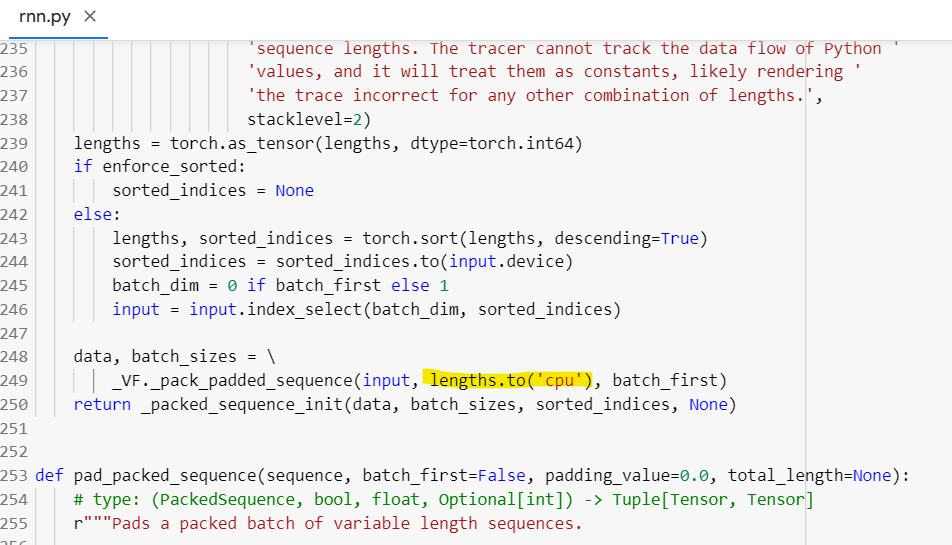


## Préparation des données

### Import des données 

On charge les données et on les converti au format JSON.


## Préparation des données

### Import des données 

On charge les données et on les converti au format JSON.

In [ ]:
from google.colab import  drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
my_path = "/drive/My Drive/"

In [ ]:
import json
import re

def search_entity(sentence):
    e1 = re.findall(r'<e1>(.*)</e1>', sentence)[0]
    e2 = re.findall(r'<e2>(.*)</e2>', sentence)[0]
    sentence = sentence.replace('<e1>' + e1 + '</e1>', ' <e1> ' + e1 + ' </e1> ', 1)
    sentence = sentence.replace('<e2>' + e2 + '</e2>', ' <e2> ' + e2 + ' </e2> ', 1)
    sentence = sentence.split()
    sentence = ' '.join(sentence)
    sentence = sentence.replace('< e1 >', '<e1>')
    sentence = sentence.replace('< e2 >', '<e2>')
    sentence = sentence.replace('< /e1 >', '</e1>')
    sentence = sentence.replace('< /e2 >', '</e2>')
    sentence = sentence.split()

    assert '<e1>' in sentence
    assert '<e2>' in sentence
    assert '</e1>' in sentence
    assert '</e2>' in sentence

    return sentence


def convert(path_src, path_des):
    with open(path_src, 'r', encoding='utf-8') as fr:
        data = fr.readlines()
        
    with open(path_des, 'w', encoding='utf-8') as fw:
        for i in range(0, len(data), 3):
            id_s, sentence = data[i].strip().split('  ')
            sentence = sentence[1:-1]
            sentence = search_entity(sentence)
            meta = dict(
                id=id_s,
                relation=data[i+1].strip(),
                sentence=sentence,
                comment=data[i+2].strip()[8:]
            )
            json.dump(meta, fw, ensure_ascii=False)
            fw.write('\n')


path_train = my_path + 'pre_train.txt'
path_test = my_path +'pre_test.txt'
path_valid = my_path +'pre_test.txt'

convert(path_train, my_path + '/train1.json')
convert(path_test, my_path +'/test1.json')
convert(path_test, my_path +'/valid1.json')

### Import des embeddings

In [ ]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


def load_embedding(path_word = my_path +'/embeddings/glove.6B.300d.txt' , word_dim = 300):
    word2id = dict()  
    word_vec = list() 

    word2id['PAD'] = len(word2id)   
    word2id['UNK'] = len(word2id)  
    word2id['<e1>'] = len(word2id)
    word2id['<e2>'] = len(word2id)
    word2id['</e1>'] = len(word2id)
    word2id['</e2>'] = len(word2id)

    with open(path_word, 'r', encoding='utf-8') as fr:
        for line in fr:
            line = line.strip().split()
            if len(line) != word_dim + 1:
                continue
            word2id[line[0]] = len(word2id)
            word_vec.append(np.asarray(line[1:], dtype=np.float32))

    word_vec = np.stack(word_vec)
    vec_mean, vec_std = word_vec.mean(), word_vec.std()
    special_emb = np.random.normal(vec_mean, vec_std, (6, word_dim))
    special_emb[0] = 0  # <pad> est initialisé à zéro

    word_vec = np.concatenate((special_emb, word_vec), axis=0)
    word_vec = word_vec.astype(np.float32).reshape(-1, word_dim)
    word_vec = torch.from_numpy(word_vec)
    return word2id, word_vec

word2id, word_vec = load_embedding(path_word = my_path +'/embeddings/glove.6B.300d.txt' , word_dim = 300)

### Import des relations

In [ ]:
def load_relation(data_dir = my_path):
    relation_file = os.path.join(data_dir, 'relation2id.txt')
    rel2id = {}
    id2rel = {}
    with open(relation_file, 'r', encoding='utf-8') as fr:
        for line in fr:
            if line.strip().split():
    
              relation, id_s = line.strip().split()
              id_d = int(id_s)
              rel2id[relation] = id_d
              id2rel[id_d] = relation
    return rel2id, id2rel, len(rel2id)

rel2id, id2rel, class_num = load_relation()

### Traitement des données et itérateurs

In [ ]:
class BrevetsDateset(Dataset):
    def __init__(self, filename, rel2id, word2id, max_len):
        self.filename = filename
        self.rel2id = rel2id
        self.word2id = word2id
        self.max_len = max_len
        self.data_dir = my_path
        self.dataset, self.label = self.__load_data()

    def __symbolize_sentence(self, sentence):
      
        mask = [1] * len(sentence)
        words = []
        length = min(self.max_len, len(sentence))
        mask = mask[:length]

        for i in range(length):
            words.append(self.word2id.get(sentence[i].lower(), self.word2id['UNK']))

        if length < self.max_len:
            for i in range(length, self.max_len):
                mask.append(0)  # 'PAD' mask is zero
                words.append(self.word2id['PAD'])

        unit = np.asarray([words, mask], dtype=np.int64)
        unit = np.reshape(unit, newshape=(1, 2, self.max_len))
        return unit

    def __load_data(self):
        path_data_file = os.path.join(self.data_dir, self.filename)
        data = []
        labels = []
        with open(path_data_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = json.loads(line.strip())
                label = line['relation']
                sentence = line['sentence']
                label_idx = self.rel2id[label]

                one_sentence = self.__symbolize_sentence(sentence)
                data.append(one_sentence)
                labels.append(label_idx)
        return data, labels

    def __getitem__(self, index):
        data = self.dataset[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        return len(self.label)

In [ ]:
class BrevetsDataLoader(object):
    def __init__(self, rel2id, word2id, batch_size, max_len):
        self.rel2id = rel2id
        self.word2id = word2id
        self.batch_size = batch_size
        self.max_len = max_len

    def __collate_fn(self, batch):
        data, label = zip(*batch)  # unzip the batch data
        data = list(data)
        label = list(label)
        data = torch.from_numpy(np.concatenate(data, axis=0))
        label = torch.from_numpy(np.asarray(label, dtype=np.int64))
        return data, label

    def __get_data(self, filename,  shuffle=False):
        dataset = BrevetsDateset(filename, self.rel2id, self.word2id, self.max_len)
        loader = DataLoader(
            dataset=dataset,
            batch_size= self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            collate_fn=self.__collate_fn
        )
        return loader

    def get_train(self):
        return self.__get_data('train1.json', shuffle=True)

    def get_dev(self):
        return self.__get_data('valid1.json', shuffle=False)

    def get_test(self):
        return self.__get_data('test1.json', shuffle=False)

batch_size = 10
max_len = 90
loader = BrevetsDataLoader(rel2id, word2id, batch_size, max_len)

test_loader = loader.get_test()
train_loader = loader.get_train()
valid_loader = loader.get_dev()

## Modèle

 - Architecture générale : 
 
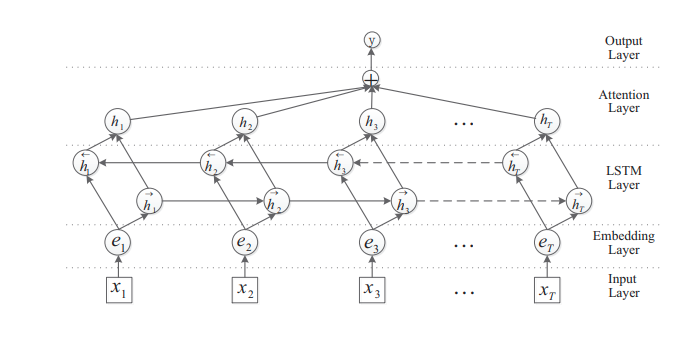

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Att_BLSTM(nn.Module):
    def __init__(self, word_vec, class_num, max_len, word_dim, hidden_size, layers_num, dropout):
        super().__init__()
        self.word_vec = word_vec
        self.class_num = class_num

        self.max_len = max_len
        self.word_dim = word_dim
        self.hidden_size = hidden_size
        self.layers_num = layers_num
        self.dropout_value = dropout

        self.word_embedding = nn.Embedding.from_pretrained(
            embeddings=self.word_vec,
            freeze=False,
        )
        self.lstm = nn.LSTM(
            input_size=self.word_dim,
            hidden_size=self.hidden_size,
            num_layers=self.layers_num,
            bias=True,
            batch_first=True,
            dropout=self.dropout_value,
            bidirectional=True,
        )
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(self.dropout_value)

        self.att_weight = nn.Parameter(torch.randn(1, self.hidden_size, 1))
        self.dense = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.class_num,
            bias=True
        )
        init.xavier_normal_(self.dense.weight)
        init.constant_(self.dense.bias, 0.)

    def lstm_layer(self, x, mask):
        lengths = torch.sum(mask.gt(0), dim=-1)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        h, (_, _) = self.lstm(x)
        h, _ = pad_packed_sequence(h, batch_first=True, padding_value=0.0, total_length=self.max_len)
        h = h.view(-1, self.max_len, 2, self.hidden_size)
        h = torch.sum(h, dim=2)  
        return h

    def attention_layer(self, h, mask):
        att_weight = self.att_weight.expand(mask.shape[0], -1, -1) 
        att_score = torch.bmm(self.tanh(h), att_weight)  
        mask = mask.unsqueeze(dim=-1)  
        att_score = att_score.masked_fill(mask.eq(0), float('-inf')) 
        att_weight = F.softmax(att_score, dim=1) 
        reps = torch.bmm(h.transpose(1, 2), att_weight).squeeze(dim=-1) 
        reps = self.tanh(reps)  
        return reps

    def forward(self, data):
        token = data[:, 0, :].contiguous().view(-1, self.max_len)
        mask = data[:, 1, :].contiguous().view(-1, self.max_len)
        emb = self.word_embedding(token) 
        emb = self.dropout(emb)
        h = self.lstm_layer(emb, mask) 
        h = self.dropout(h)
        reps = self.attention_layer(h, mask) 
        reps = self.dropout(reps)
        logits = self.dense(reps)
        return logits


In [ ]:
torch.device('cuda')

device(type='cuda')

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device=torch.device('cuda')
def count_parameters(model): 
    s = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Le modèle a {s:,} paramètres à entraîner')


model = Att_BLSTM(word_vec = word_vec, class_num = class_num, max_len = 90, word_dim = 300, hidden_size = 100, layers_num = 1, dropout = 0.5).to(device) 

count_parameters(model)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Le modèle a 120,324,813 paramètres à entraîner


### Optimiseur

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)

def optimiseur(model, lr=3e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

### Métriques

In [ ]:
from sklearn.metrics import f1_score
import math


def f1_loss(predict_label, true_label, class_num=class_num):
    
    assert true_label.shape[0] == predict_label.shape[0]
    confusion_matrix = np.zeros(shape=[class_num, class_num], dtype=np.float32)
    xDIRx = np.zeros(shape=[class_num], dtype=np.float32)
    for i in range(true_label.shape[0]):
        true_idx = math.ceil(true_label[i]/2)
        predict_idx = math.ceil(predict_label[i]/2)
        if true_label[i] == predict_label[i]:
            confusion_matrix[predict_idx][true_idx] += 1
        else:
            if true_idx == predict_idx:
                xDIRx[predict_idx] += 1
            else:
                confusion_matrix[predict_idx][true_idx] += 1

    col_sum = np.sum(confusion_matrix, axis=0).reshape(-1)
    row_sum = np.sum(confusion_matrix, axis=1).reshape(-1)
    f1 = np.zeros(shape=[class_num], dtype=np.float32)

    for i in range(0, class_num): 
        try:
            p = float(confusion_matrix[i][i]) / float(col_sum[i] + xDIRx[i])
            r = float(confusion_matrix[i][i]) / float(row_sum[i] + xDIRx[i])
            f1[i] = (2 * p * r / (p + r))
        except:
            pass
    actual_class = 0
    total_f1 = 0.0
    for i in range(1, class_num):
        if f1[i] > 0.0: 
            actual_class += 1
            total_f1 += f1[i]
    try:
        macro_f1 = total_f1 / actual_class
    except:
        macro_f1 = 0.0
    return macro_f1

## Entraînement

In [ ]:
def train_model(model, iterator, optimizer, criterion):
    predict_label = []
    true_label = []
    total_loss = 0.0
    acc = []
    for _, (data, label) in enumerate(iterator):
        model.train()
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, label)
        
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=5)
        optimizer.step()
        total_loss += loss.item() 

        _, pred = torch.max(logits, dim=1) 
        pred = pred.cpu().detach().numpy().reshape((-1, 1))
        label = label.cpu().detach().numpy().reshape((-1, 1))
        predict_label.append(pred)
        true_label.append(label)
        
    predict_label = np.concatenate(predict_label, axis=0).reshape(-1).astype(np.int64)
    true_label = np.concatenate(true_label, axis=0).reshape(-1).astype(np.int64)
    eval_loss = total_loss / predict_label.shape[0]

    f1 = f1_loss(predict_label, true_label)
    
    return f1, eval_loss

def evaluate(model, iterator, criterion):
       
    predict_label = []
    true_label = []
    total_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for _, (data, label) in enumerate(iterator):
            data = data.to(device)
            label = label.to(device)

            logits = model(data)
            loss = criterion(logits, label)
            
            total_loss += loss.item()

            _, pred = torch.max(logits, dim=1)  
            pred = pred.cpu().detach().numpy().reshape((-1, 1))
            label = label.cpu().detach().numpy().reshape((-1, 1))
            predict_label.append(pred)
            true_label.append(label)
    predict_label = np.concatenate(predict_label, axis=0).reshape(-1).astype(np.int64)
    true_label = np.concatenate(true_label, axis=0).reshape(-1).astype(np.int64)
    eval_loss = total_loss / predict_label.shape[0]

    f1 = f1_loss(predict_label, true_label)
    
    return f1, eval_loss, predict_label, true_label
    

In [ ]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def entrainement(model, optimizer, batch_size = 10, N_EPOCHS = 50):
    t_loss = []
    t_f1 = []
    v_loss = []
    v_f1 = []
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
       

        start_time = time.time()

        train_f1, train_loss = train_model(model, train_loader, optimizer, criterion)
        t_loss.append(train_loss)
        t_f1.append(train_f1) 
        
        valid_f1, valid_loss,_,_ = evaluate(model, valid_loader, criterion)
        v_loss.append(valid_loss)
        v_f1.append(valid_f1)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model_ner.pt')

       
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')
    return t_loss, v_loss, t_f1, v_f1

In [ ]:
N_EPOCHS = 37

t_l, v_l, t_f1, v_f1 = entrainement(model, optimiseur(model, lr = 1e-4, weight_decay_rate = 0.001), N_EPOCHS = N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.195 | Train F1 score: 12.78%
	 Val. Loss: 0.166 |  Val. F1 score: 58.80%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.172 | Train F1 score: 22.81%
	 Val. Loss: 0.151 |  Val. F1 score: 58.82%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.157 | Train F1 score: 24.71%
	 Val. Loss: 0.127 |  Val. F1 score: 41.32%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.137 | Train F1 score: 37.57%
	 Val. Loss: 0.109 |  Val. F1 score: 54.50%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.122 | Train F1 score: 40.07%
	 Val. Loss: 0.097 |  Val. F1 score: 63.86%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 0.111 | Train F1 score: 53.83%
	 Val. Loss: 0.089 |  Val. F1 score: 66.84%
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 0.103 | Train F1 score: 59.48%
	 Val. Loss: 0.084 |  Val. F1 score: 68.69%
Epoch: 08 | Epoch Time: 0m 33s
	Train Loss: 0.095 | Train F1 score: 62.88%
	 Val. Loss: 0.085 |  Val. F1 score: 68.94%
Epoch: 09 | Epoch Time: 0m 33s
	Train Loss: 0.09

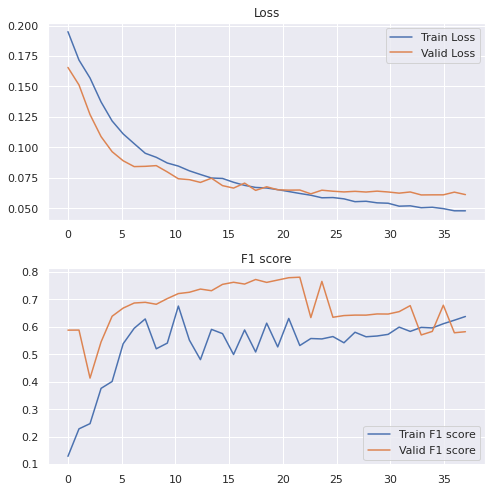

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

f = plt.figure(figsize=(7, 7))
gs = f.add_gridspec(2, 1)
x = np.linspace(0, N_EPOCHS,N_EPOCHS)
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0])
    plt.plot(x,t_l, label='Train Loss')
    plt.plot(x,v_l, label='Valid Loss')
    plt.title("Loss")
    plt.legend()
        
    ax = f.add_subplot(gs[1])
    plt.plot(x, t_f1, label='Train F1 score')
    plt.plot(x, v_f1, label='Valid F1 score')
    plt.title("F1 score")
    plt.legend()

       
f.tight_layout()

## Test

In [ ]:
model.load_state_dict(torch.load('tut2-model_ner.pt'))
f1, eval_loss, preds, labels= evaluate(model, test_loader, criterion)

print(f'Test Loss: {eval_loss:.3f} |  Test F1 score: {f1*100:.2f}%')

Test Loss: 0.061 |  Test F1 score: 57.05%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predict =  preds
true =  labels

positive_labels = [i for i in range(len(rel2id)) if i != 0]
positive_names = [list(rel2id.keys())[list(rel2id.values()).index(i)] for i in range(len(rel2id)) if i != 0]
print(classification_report(
                y_true=true,
                y_pred=predict,
                labels=positive_labels,
                target_names=positive_names
            ))

                          precision    recall  f1-score   support

         produces(e1,e2)       0.91      0.94      0.93       760
         anaphora(e1,e2)       0.82      0.94      0.88       181
             is_a(e1,e2)       0.83      0.90      0.86       146
         is_acron(e1,e2)       0.00      0.00      0.00         3
increases_risk_of(e1,e2)       0.50      0.05      0.08        22
         is_synon(e1,e2)       0.00      0.00      0.00         5
         produces(e2,e1)       0.83      0.77      0.80       294
         anaphora(e2,e1)       0.68      0.83      0.74       104
             is_a(e2,e1)       0.50      0.26      0.34        38
         is_acron(e2,e1)       0.74      0.78      0.76        51
increases_risk_of(e2,e1)       0.20      0.09      0.13        22
         is_synon(e2,e1)       0.75      0.17      0.27        18

                accuracy                           0.84      1644
               macro avg       0.56      0.48      0.48      1644
        

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

confusion = confusion_matrix(true, predict)
l = positive_names

confusion_df =pd.DataFrame(confusion)

confusion_df.columns=l
s = pd.Series(l)
confusion_df = confusion_df.set_index([s])


confusion_df

,"produces(e1,e2)","anaphora(e1,e2)","is_a(e1,e2)","is_acron(e1,e2)","increases_risk_of(e1,e2)","is_synon(e1,e2)","produces(e2,e1)","anaphora(e2,e1)","is_a(e2,e1)","is_acron(e2,e1)","increases_risk_of(e2,e1)","is_synon(e2,e1)"
"produces(e1,e2)",718,7,3,0,0,0,20,2,5,4,1,0
"anaphora(e1,e2)",6,170,0,0,0,0,5,0,0,0,0,0
"is_a(e1,e2)",4,6,131,0,0,0,2,3,0,0,0,0
"is_acron(e1,e2)",0,1,0,0,0,0,0,1,0,0,1,0
"increases_risk_of(e1,e2)",8,2,4,0,1,0,4,0,0,1,2,0
"is_synon(e1,e2)",0,1,2,0,0,0,0,0,1,0,0,1
"produces(e2,e1)",36,8,0,0,0,0,226,17,2,4,1,0
"anaphora(e2,e1)",3,5,1,0,0,0,7,86,0,1,1,0
"is_a(e2,e1)",6,4,5,0,0,0,1,9,10,1,2,0
"is_acron(e2,e1)",1,2,0,0,0,0,3,5,0,40,0,0


## Références : 

 - [Attention-Based Bidirectional Long Short-Term Memory Networks for
Relation Classification](https://www.aclweb.org/anthology/P16-2034.pdf)
 - [Att-BLSTM-relation-extraction](https://github.com/onehaitao/Att-BLSTM-relation-extraction)